In [1]:
#import python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#import python packages for working with .cool, .bigwig and .gtf files
import cooler
import cooltools
import pyBigWig
from gtfparse import read_gtf

In [38]:
# import HiC in .cool or .mcool 
# note: if you are importing HiC in .mcool file, you should specify the resolution
clr = cooler.Cooler('[pass to your .cool or .mcool file]/GSE130275_mESC_WT_combined_2.6B.mcool::/12')
resolution = clr.binsize
print(resolution)

3200


In [39]:
# computing the expected values for each diagonal in cis
view_df=pd.DataFrame({'chrom':clr.chromnames,
                      'start':0,
                      'end':clr.chromsizes.values,
                      'name':clr.chromnames})
expected = cooltools.expected_cis(clr, view_df=view_df, nproc=2, chunksize=1_000_000)

In [27]:
# import gene annotation in .gft file to extract gene/transcript information
df_gene0 = read_gtf("[pass to your .gtf file]/mm10.ensGene.gtf")
df_gene0 = df_gene0[df_gene0['feature']=="transcript"]
df_gene0 = df_gene0[['seqname','start','end','strand','gene_id']]
df_gene0['length'] = df_gene0['end']-df_gene0['start']
df_gene0 = df_gene0.sort_values('length', ascending=False).drop_duplicates('gene_id')
df_gene0 = df_gene0.rename(columns = {'seqname': 'chrom'}, inplace = False)
df_gene0 = df_gene0.sort_values(['chrom','start'])
df_gene0 = df_gene0[df_gene0['chrom'].isin(clr.chromnames)]
display(df_gene0)

/Users/hsalari/opt/miniconda3/lib/python3.7/site-packages/gtfparse/read_gtf.py:154: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  features=features)
/Users/hsalari/opt/miniconda3/lib/python3.7/site-packages/gtfparse/read_gtf.py:154: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  features=features)
INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_name', 'exon_number', 'exon_id']


,chrom,start,end,strand,gene_id,length
0,chr1,3073253,3074322,+,ENSMUSG00000102693,1069
2,chr1,3102016,3102125,+,ENSMUSG00000064842,109
10,chr1,3214482,3671498,-,ENSMUSG00000051951,457016
21,chr1,3252757,3253236,+,ENSMUSG00000102851,479
23,chr1,3365731,3368549,-,ENSMUSG00000103377,2818
...,...,...,...,...,...,...
1449882,chrY,90753057,90763485,+,ENSMUSG00000095134,10428
1449890,chrY,90754513,90754821,-,ENSMUSG00000095366,308
1449895,chrY,90784738,90816439,+,ENSMUSG00000096768,31701
1449950,chrY,90837413,90844040,+,ENSMUSG00000099871,6627


In [44]:
# select a subset of genes based on size
# Note: the minimum size of the gene is better to be at least 20 times higher than HiC resolution
lmin = 20*resolution
lmax = 40*resolution
df_gene = df_gene0[(df_gene0['length']<lmax)&(df_gene0['length']>lmin)]
df_gene = df_gene.reset_index(drop=True)
display(df_gene)

,chrom,start,end,strand,gene_id,length
0,chr1,3905739,3986215,-,ENSMUSG00000102343,80476
1,chr1,4290846,4409241,-,ENSMUSG00000025900,118395
2,chr1,4807892,4886770,+,ENSMUSG00000104217,78878
3,chr1,5070018,5162340,+,ENSMUSG00000033793,92322
4,chr1,7088920,7173628,+,ENSMUSG00000051285,84708
...,...,...,...,...,...,...
2300,chrY,725128,797405,-,ENSMUSG00000053211,72277
2301,chrY,2106175,2170409,-,ENSMUSG00000000103,64234
2302,chrY,11345842,11426704,-,ENSMUSG00000101789,80862
2303,chrY,13252442,13378797,+,ENSMUSG00000093903,126355


In [41]:
# compute Intra-gene RNA Pol II (IR) score from PolII ChIP-seq data in BigWig format
pol2 = pyBigWig.open("[pass to your .bigwig file]/GSM4173524_DMSO-N20-input_rep1.bw")
l = len(df_gene)
for i in range(l):
    ch = df_gene.chrom[i]
    start = df_gene.start[i]
    end = df_gene.end[i]
    df_gene.loc[i,'ir_score'] = np.mean(pol2.values(ch,start,end))
df_gene.loc[:,'log2_ir_score'] = np.log2(df_gene['ir_score'])

display(df_gene)

,chrom,start,end,strand,gene_id,length,ir_score,log2_ir_score
0,chr1,3905739,3986215,-,ENSMUSG00000102343,80476,0.274052,-1.867477
1,chr1,4290846,4409241,-,ENSMUSG00000025900,118395,0.251791,-1.989699
2,chr1,4807892,4886770,+,ENSMUSG00000104217,78878,4.901177,2.293128
3,chr1,5070018,5162340,+,ENSMUSG00000033793,92322,2.676813,1.420517
4,chr1,7088920,7173628,+,ENSMUSG00000051285,84708,1.395533,0.480816
...,...,...,...,...,...,...,...,...
2300,chrY,725128,797405,-,ENSMUSG00000053211,72277,0.169336,-2.562041
2301,chrY,2106175,2170409,-,ENSMUSG00000000103,64234,0.116129,-3.106195
2302,chrY,11345842,11426704,-,ENSMUSG00000101789,80862,0.099422,-3.330286
2303,chrY,13252442,13378797,+,ENSMUSG00000093903,126355,0.131451,-2.927398


In [42]:
# select genes based on IR scores
IRmin = 1
IRmax = 2
sub_df_gene = df_gene[(df_gene['log2_ir_score']<IRmax)&(df_gene['log2_ir_score']>IRmin)]
sub_df_gene = sub_df_gene.reset_index(drop=True)
display(sub_df_gene)

,chrom,start,end,strand,gene_id,length,ir_score,log2_ir_score
0,chr1,5070018,5162340,+,ENSMUSG00000033793,92322,2.676813,1.420517
1,chr1,10038217,10136768,+,ENSMUSG00000056763,98551,2.405323,1.266231
2,chr1,30802339,30873581,-,ENSMUSG00000048874,71242,2.873952,1.523036
3,chr1,39371492,39478755,-,ENSMUSG00000003134,107263,2.979552,1.575096
4,chr1,39900913,40026310,+,ENSMUSG00000026074,125397,2.898297,1.535206
...,...,...,...,...,...,...,...,...
309,chr9,115242607,115310421,-,ENSMUSG00000032437,67814,2.359291,1.238353
310,chr9,119238432,119322427,-,ENSMUSG00000036737,83995,2.593042,1.374646
311,chr9,122951081,123018725,+,ENSMUSG00000036768,67644,3.476441,1.797611
312,chrX,50555744,50635261,-,ENSMUSG00000085396,79517,3.975932,1.991293


Text(0.5, 1.0, '64<length<128kb\n1<Log2 IR score<2')

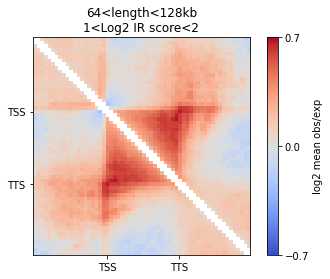

In [43]:
# pileup mtea-gene analysis (PMGA) of intra-gene HiC contact map
def get_row_compressor(old_dimension, new_dimension):
    dim_compressor = np.zeros((new_dimension, old_dimension))
    bin_size = float(old_dimension) / new_dimension
    next_bin_break = bin_size
    which_row = 0
    which_column = 0
    while which_row < dim_compressor.shape[0] and which_column < dim_compressor.shape[1]:
        if round(next_bin_break - which_column, 10) >= 1:
            dim_compressor[which_row, which_column] = 1
            which_column += 1
        elif next_bin_break == which_column:

            which_row += 1
            next_bin_break += bin_size
        else:
            partial_credit = next_bin_break - which_column
            dim_compressor[which_row, which_column] = partial_credit
            which_row += 1
            dim_compressor[which_row, which_column] = 1 - partial_credit
            which_column += 1
            next_bin_break += bin_size
    dim_compressor /= bin_size
    return dim_compressor


def get_column_compressor(old_dimension, new_dimension):
    return get_row_compressor(old_dimension, new_dimension).transpose()

def compress_and_average(array, new_shape):
    # Note: new shape should be smaller in both dimensions than old shape
    return np.mat(get_row_compressor(array.shape[0], new_shape[0])) * \
           np.mat(array) * \
           np.mat(get_column_compressor(array.shape[1], new_shape[1]))

sub_df_gene['mid'] = sub_df_gene['end']
sub_df_gene['start'] = sub_df_gene['end']-1
sub_df_gene['end'] = sub_df_gene['end']+1
flank = 2*max(sub_df_gene.length)
stack = cooltools.pileup(clr, sub_df_gene, view_df=view_df, expected_df=expected, flank=flank)
lm = sub_df_gene.length[0]//resolution
fm = flank//resolution
m1 = fm-2*lm
m2 = fm+lm
mtx0 = stack[m1:m2,m1:m2,0]
stk = np.asarray(compress_and_average(mtx0, (60, 60)))
l = len(sub_df_gene)
for i in range (1,l):
    lm = sub_df_gene.length[i]//resolution
    m1 = fm-2*lm
    m2 = fm+lm
    mtx0 = stack[m1:m2,m1:m2,i]
    mtx0 = np.asarray(compress_and_average(mtx0, (60, 60)))
    stk = np.dstack((stk,mtx0))
mask = np.array(sub_df_gene.strand == '-', dtype=bool)
stk[:, :, mask] = stk[::-1, ::-1, mask]
mtx = np.nanmean(stk, axis=2)

np.fill_diagonal(mtx, np.nan)
lm = len(mtx)-1
for i in range(lm):
    mtx[i,i+1] = np.nan
    mtx[i+1,i] = np.nan

plt.imshow(
    np.log2(mtx),
    vmax = 0.7,
    vmin = -0.7,
    cmap='coolwarm',
    interpolation='none')

plt.colorbar(label = 'log2 mean obs/exp',ticks=[-0.7, 0, 0.7])
ticks_pixels = [20,40]
ticks_label = ['TSS','TTS']
plt.xticks(ticks_pixels, ticks_label)
plt.yticks(ticks_pixels, ticks_label)
plt.title(str(lmin//1000)+'<length<'+str(lmax//1000)+'kb\n'
          +str(IRmin)+'<Log2 IR score<'+str(IRmax))